In [1]:
import random
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange, stencil

In [2]:
from common import initialize_fields, plot_field

In [3]:
from stencil2d import laplacian, update_halo, apply_diffusion

In [4]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

# Accelerate with Numba

From Numba docs:

> Numba is a just-in-time compiler for Python that works best on code that uses NumPy arrays and functions, and loops. (...) When a call is made to a Numba-decorated function it is compiled to machine code “just-in-time” for execution and all or part of your code can subsequently run at native machine code speed!

> With a few simple annotations, array-oriented and math-heavy Python code can be just-in-time optimized to performance similar
as C, C++ and Fortran, without having to switch languages or Python interpreters.

The goal of this notebook is to show how we can use Numba and check whether we observe a performance gain compared to the results in [the first Jupyter notebook](1_lists_numpy.ipynb). We will restrict the tests to the cases where we used Numpy arrays. Also, since Numba is a huge module, we will focus on testing the following components, which we believe are the most relevant features for stencil computations:

1. `@numba.jit(nopython=True)` or `@numba.njit`
2. `numba.prange` together with `parallel=True`
3. `@numba.stencil`

Again, from the Numba docs:

> The Numba @jit decorator fundamentally operates in two compilation modes, nopython mode and object mode. (...) The behaviour of the nopython compilation mode is to essentially compile the decorated function so that it will run entirely without the involvement of the Python interpreter. This is the recommended and best-practice way to use the Numba jit decorator as it leads to the best performance.

> Assuming Numba can operate in nopython mode, or at least compile some loops, it will target compilation to your
specific CPU. Speed up varies depending on application but can be one to two orders of magnitude.

# Pointwise stencil

## Arrays with loops

Functions in this notebook are a bit different from the previous notebook. In the first place they don't use the `timeit.default_timer()` function, since Numba cannot deal with this function. For the same reason, the option to plot `out_fiel` is also removed, but `out_fiel` is now always returned.

In [5]:
@jit(nopython=True)
def array_numba_pointwise(in_field, out_field):
    for iter in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

One has to be carefull to measure the performance using Numba. We are warned about this in the docs:

> A really common mistake when measuring performance is to not account for the above behaviour and to time code
once with a simple timer that includes the time taken to compile your function in the execution time.

For this reason, we will always execute a function at least once before benchmarking with `%timeit`.

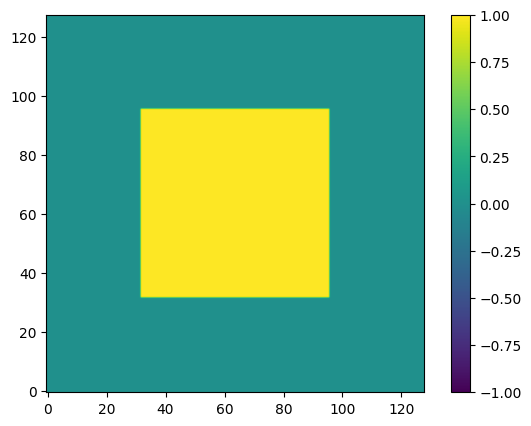

In [6]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
plot_field(in_field)

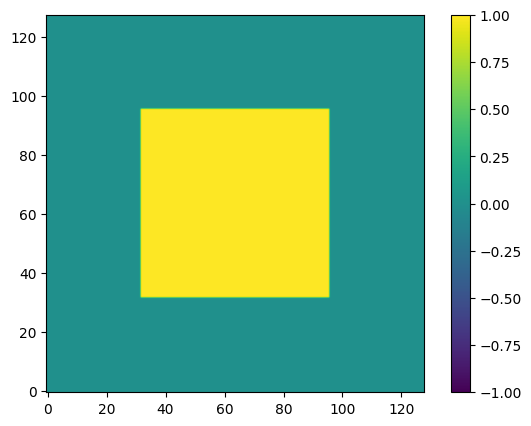

In [7]:
# This call is just so that Numba compiles the function before we benchmark
out_field = array_numba_pointwise(in_field, out_field)
plot_field(out_field)

In [8]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_numba_pointwise(in_field, out_field)

44.9 ms ± 70 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Numba works! The exact speedup is platform specific, but when comparing the numbers running everything in the CSCS JupyterLab we observe that this code is **~150x faster** that pure python code (lists) and **~300x faster** than using numpy arrays while keeping the `for` loops. It is astonishing that this is achieved by just adding a simple decorator on top of the function definition! This code is even faster than the pure numpy copy code.

| Function                  | Time    |
|:--------------------------|--------:|
| `list_pointwise()`        |  8.4s   |
| `array_pointwise()`       |  15.3s  |
| `numpy_pointwise()`       |  60.8ms |
| `array_numba_pointwise()` |  44.9ms |

In [9]:
@jit(nopython=True)
def array_numba_sin_pointwise(in_field, out_field):
    for iter in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = math.sin(in_field[k, j, i])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

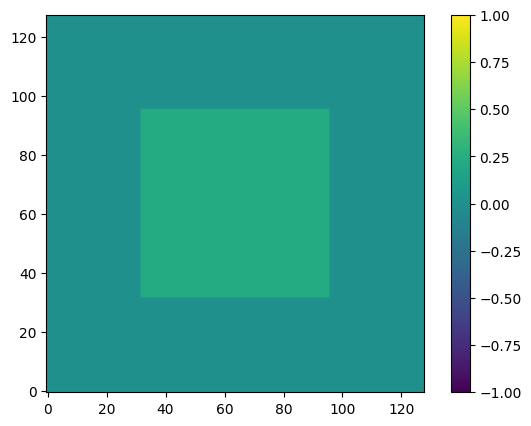

In [10]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
out_field = array_numba_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [11]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_numba_sin_pointwise(in_field, out_field)

398 ms ± 780 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Applying `sin()` instead of a simple copy we also observed a very noticable increase in performance. It is **~30x faster** than pure python code (lists) and **~50x faster** than numpy arrays with `for` loops. Again, it is even faster than using the vectorized Numpy function.

| Function                      | Time   |
|:------------------------------|-------:|
| `list_sin_pointwise()`        |  13.6s |
| `array_sin_pointwise()`       |  22.8s |
| `numpy_sin_pointwise()`       |  406ms |
| `array_numba_sin_pointwise()` |  398ms |

We can improve even more our performance by using all the cores of the CPU. `@jit` supports the argument `parallel=True`.

> If code contains operations that are parallelisable (and supported) Numba can compile a version that will run in parallel
on multiple native threads (no GIL!).

In addition, we can do something similar to what we did with OpenMP and Fortran.

> Numba parallel execution also has support for explicit parallel loop declaration similar to that in OpenMP. To indicate
that a loop should be executed in parallel the numba.prange function should be used, this function behaves like Python
range and if parallel=True is not set it acts simply as an alias of range.

In [12]:
@jit(nopython=True, parallel=True)
def array_numba_parallel_sin_pointwise(in_field, out_field):
    for iter in range(N_ITER):
        # We use prange instead of range for the Z axis
        for k in prange(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = math.sin(in_field[k, j, i])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

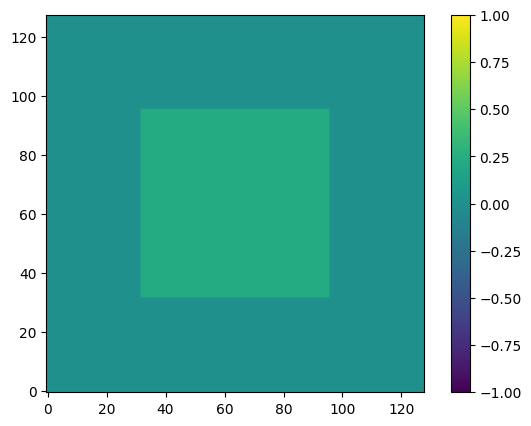

In [13]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
out_field = array_numba_parallel_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [14]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_numba_parallel_sin_pointwise(in_field, out_field)

46.6 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Using `prange` and `parallel=True` we can make this code **~8x faster** that the vectorized numpy code. This speedup, however, depends on the number of cores we have available.

| Function                               | Time   |
|:---------------------------------------|-------:|
| `list_sin_pointwise()`                 | 13.6s  |
| `array_sin_pointwise()`                | 22.8s  |
| `numpy_sin_pointwise()`                | 406ms  |
| `array_numba_sin_pointwise()`          | 398ms  |
| `array_numba_parallel_sin_pointwise()` | 46.6ms |

## Arrays without loops

In this section we will show that Numba is not able to optimize code which uses Numpy vectorized expressions.

In [15]:
@jit(nopython=True)
def numpy_numba_pointwise(in_field, out_field):
    for iter in range(N_ITER):
        out_field = in_field.copy()
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

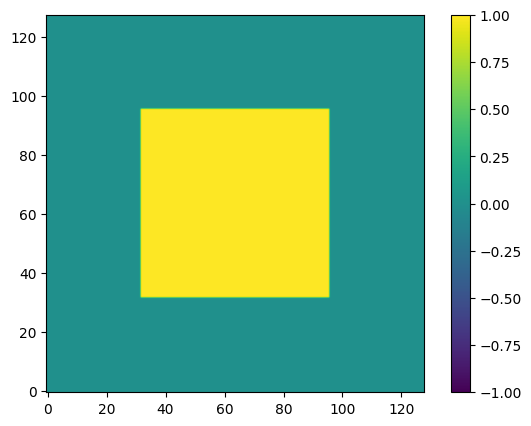

In [16]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
numpy_numba_pointwise(in_field, out_field)
plot_field(out_field)

In [17]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
numpy_numba_pointwise(in_field, out_field)

55.9 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


| Function                  | Time   |
|:--------------------------|-------:|
| `list_pointwise()`        | 8.4s   |
| `array_pointwise()`       | 15.3s  |
| `numpy_pointwise()`       | 60.8ms |
| `array_numba_pointwise()` | 44.9ms |
| `numpy_numba_pointwise()` | 55.9ms |

In [18]:
@jit(nopython=True)
def numpy_numba_sin_pointwise(in_field, out_field):
    for iter in range(N_ITER):
        out_field = np.sin(in_field)
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

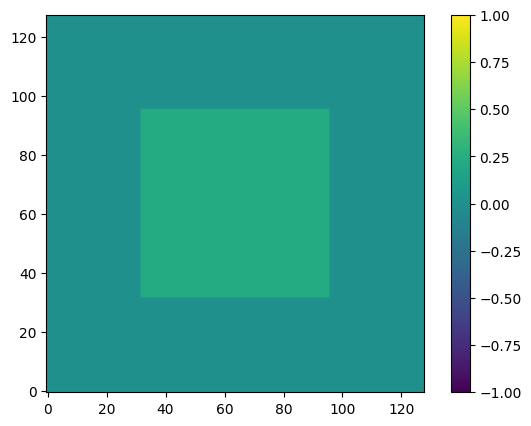

In [19]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
out_field = numpy_numba_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [20]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
numpy_numba_sin_pointwise(in_field, out_field)

420 ms ± 497 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


| Function                               | Time   |
|:---------------------------------------|-------:|
| `list_sin_pointwise()`                 | 13.6s  |
| `array_sin_pointwise()`                | 22.8s  |
| `numpy_sin_pointwise()`                | 406ms  |
| `array_numba_sin_pointwise()`          | 398ms  |
| `array_numba_parallel_sin_pointwise()` | 46.6ms |
| `numpy_numba_sin_pointwise()`          | 420ms  |

In conclusion, the best way to use Numba (at lest for the pointwise stencil) seems to keep all the `for` loops (i.e., avoid array slicing), avoid using the vectorized Numpy functions, and take advantage of all the cores by passing `parallel=True` to the `@njit` decorator. The speedup observed in this section agrees with the claims from their documentation.

# 1D stencils

With the lessons learned from the pointwise stencil, now we will focus on using numpy arrays keeping the `for` loops and checking whether we still need to keep in mind the right order of the loops or if Numba can do that for us.

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

## Arrays with loops

In [21]:
@jit(nopython=True, parallel=True)
def array_numba_parallel_1D_same_col_row_update(in_field, out_field):
    for iter in range(N_ITER):
        for k in prange(NZ):
            for i in range(NX - 1):
                for j in range(NY):
                    out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
                    # Periodic boundary condition
                    out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

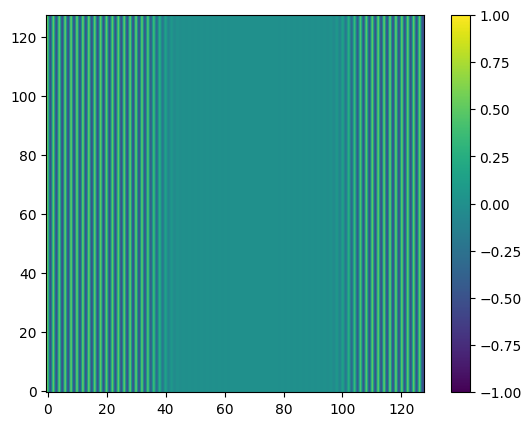

In [22]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
out_field = array_numba_parallel_1D_same_col_row_update(in_field, out_field)
plot_field(out_field)

In [23]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
array_numba_parallel_1D_same_col_row_update(in_field, out_field)

58.2 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
@jit(nopython=True, parallel=True)
def array_numba_parallel_1D_same_col_col_update(in_field, out_field):
    for iter in range(N_ITER):
        for k in prange(NZ):
            for j in range(NY):
                for i in range(NX - 1):
                    out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
                    # Periodic boundary condition
                out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

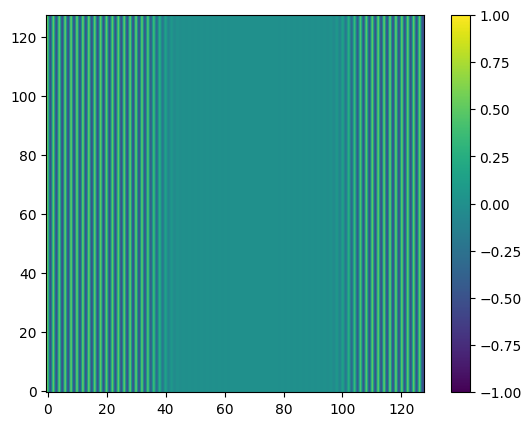

In [25]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
out_field = array_numba_parallel_1D_same_col_col_update(in_field, out_field)
plot_field(out_field)

In [26]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
array_numba_parallel_1D_same_col_col_update(in_field, out_field)

11.8 ms ± 76.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Choosing the right order for the loops is still relevant when accelerating code with Numba. This is not surprising since not only we are probably improving the cache hits when using the right order, but also we are calling less times the code that implements the periodic boundary conditions.

## Arrays without loops

In [27]:
@jit(nopython=True)
def numpy_numba_1D_same_col(in_field, out_field):    
    for iter in range(N_ITER):
        out_field[:, :, :-1] = 0.5 * (in_field[:, :, 1:] - in_field[:, :, :-1])
        # Periodic boundary condition
        out_field[:, :, -1] = 0.5 * (in_field[:, :, 0] - in_field[:, :, -1])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

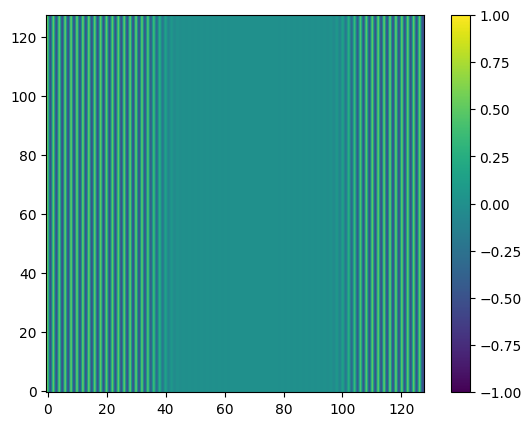

In [28]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
out_field = numpy_numba_1D_same_col(in_field, out_field)
plot_field(out_field)

In [29]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars", order="C")
numpy_numba_1D_same_col(in_field, out_field)

194 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars", order="F")
numpy_numba_1D_same_col(in_field, out_field)

638 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


| Function                                        | Time   |
|:-----------------------------------------------:|-------:|
| `numpy_1D_same_col_order_C()`                   | 202ms  |
| `numpy_1D_same_col_order_F()`                   | 135ms  |
| `array_numba_parallel_1D_same_col_row_update()` | 58.2ms |
| `array_numba_parallel_1D_same_col_col_update()` | 11.8ms |
| `numpy_numba_1D_same_col_order_C()`             | 194ms  |
| `numpy_numba_1D_same_col_order_F()`             | 638ms  |

The summary of this table and main conclusion is that Numba can speedup the 1D stencil code but updating the field in the right order is still relevant. In the ideal scenario, Numba code is **~11x faster** that the Numpy code.

Using Numba against pure numpy code without `for` loops only decreases performance. And in this case it is surprising to see that trying to use the right col-wise (Fortran style) initialization for the arrays makes the code **~3x** slower than with the default (C style) initialization. This is probably because Numba is optimized to work with the default Numpy array order (C style). In previous versions of Numba, Fortran order arrays were not even supported. For example, the parallel accelerator `@njit(parallel=True)` supports Fortran ordered arrays since version 0.53.0. So, unless there is a very good reason, C ordered arrays should be prefered.

## Same row: $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

## Arrays with loops

In [31]:
@jit(nopython=True, parallel=True)
def array_numba_parallel_1D_same_row_row_update(in_field, out_field):
    for iter in range(N_ITER):
        for k in prange(NZ):
            for i in range(NX):
                for j in range(NY-1):
                    out_field[k, j, i] = 0.5 * (in_field[k, j+1, i] - in_field[k, j, i])
                out_field[k, NY-1, i] = 0.5 * (in_field[k, 0, i] - in_field[k, NY-1, i])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

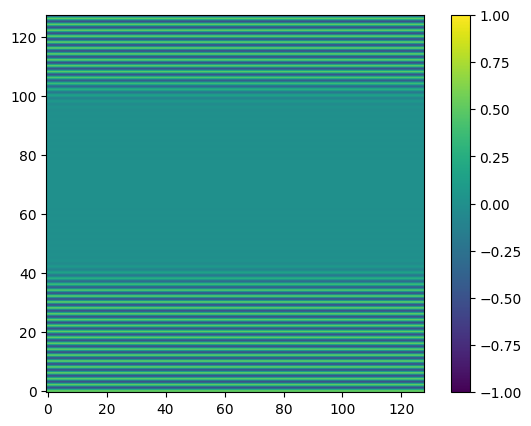

In [32]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
out_field = array_numba_parallel_1D_same_row_row_update(in_field, out_field)
plot_field(out_field)

In [33]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
array_numba_parallel_1D_same_row_row_update(in_field, out_field)

29.8 ms ± 923 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
@jit(nopython=True, parallel=True)
def array_numba_parallel_1D_same_row_col_update(in_field, out_field):
    for iter in range(N_ITER):
        for k in prange(NZ):
            for j in range(NY - 1):
                for i in range(NX):
                    out_field[k, j, i] = 0.5 * (in_field[k, j+1, i] - in_field[k, j, i])
                    out_field[k, NY-1, i] = 0.5 * (in_field[k, 0, i] - in_field[k, NY-1, i])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

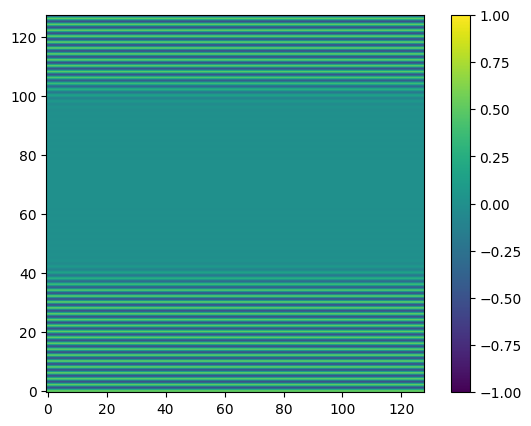

In [35]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
out_field = array_numba_parallel_1D_same_row_col_update(in_field, out_field)
plot_field(out_field)

In [36]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
array_numba_parallel_1D_same_row_col_update(in_field, out_field)

13.2 ms ± 471 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Weird result!! Double check**. The wrong order of updating the field is actually a bit faster than the correct order, which in this case.

## Arrays without loops

In [37]:
@jit(nopython=True)
def numpy_numba_1D_same_row(in_field, out_field):    
    for iter in range(N_ITER):
        out_field[:, :-1, :] = 0.5 * (in_field[:, 1:, :] - in_field[:, :-1, :])
        # Periodic boundary condition
        out_field[:, -1, :] = 0.5 * (in_field[:, 0, :] - in_field[:, -1, :])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

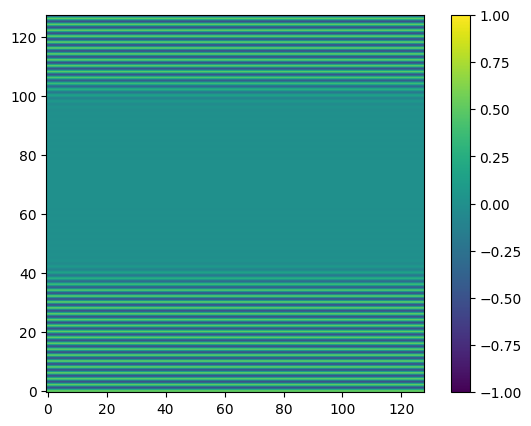

In [38]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
out_field = numpy_numba_1D_same_row(in_field, out_field)
plot_field(out_field)

In [39]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", order="C")
numpy_numba_1D_same_row(in_field, out_field)

191 ms ± 887 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", order="F")
numpy_numba_1D_same_row(in_field, out_field)

662 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2D field

The 4th-order diffusion we used in the course is the right stencil to test the `@stencil` decorator.

This is the compact laplacian function rewritten using the `@stencil` decorator. It is very simple to write stencils with Numba, but unfortunately at the moment there is not a simple way to implement the periodic boundary conditions. In the future it may be possible using the `func_or_mode` parameter. With current latest version of Numba only `func_or_mode="constan"` is supported, which means that the elements of the field outside a valid range are considered constant with the value `cval`, which by default is 0.

In [41]:
@stencil
def laplacian_numba_stencil(field):
    return -4.0 * field[0, 0, 0] + field[0, -1, 0] \
           + field[0, 1, 0] + field[0, 0, -1] + field[0, 0, 1]

In [42]:
field, lap_field = initialize_fields(NX, NY, NZ, mode="random")

In [43]:
%timeit laplacian(field, lap_field, num_halo=2, extend=0)

7.32 ms ± 39.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
%timeit laplacian_numba_stencil(field)

597 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The Numba stencil code is much slower because the `@stencil` decorator does not compile anything. It just transforms the compact code using relative coordinates into a python function with the absolute indices. The speedup can only be obtain later combining this function with `@jit`.

In order to have periodic boundaries we have to use the same trick as done in the `stencil2d.py` module, i.e., write a new `update_halo()` function. This time we write this function with `for` loops to fully benefit from the Numba "magic". We can use the `prange` on the Z axis, and reuse some of the loops.

In [45]:
@jit(nopython=True, parallel=True)
def update_halo_numba(field, num_halo):
    for k in prange(NZ):
        for j in range(num_halo):
            for i in range(NX - 2 * num_halo):
                # updating top edge (without corners)
                field[k, j, num_halo + i] = field[k, NY - 2 * num_halo + j, num_halo + i]
                # updating bottom edge (without corners)
                field[k, NY - num_halo + j, num_halo + i] = field[k, num_halo + j, num_halo + i]
        for j in range(NY):
            for i in range(num_halo):
                # updating left edge (with corners)
                field[k, j, i] = field[k, j, NX - 2 * num_halo + i]
                # updating right edge (with corners)
                field[k, j, NX - num_halo + i] = field[k, j, num_halo + i]

Let's tests the `update_halo_numba()` against the implementation from `stencil2d.py`.

True

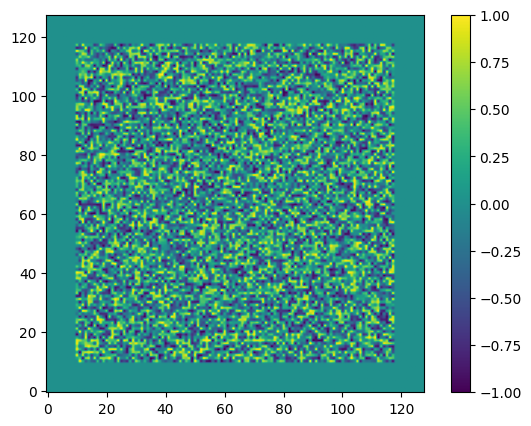

In [46]:
field, copy_field = initialize_fields(NX, NY, NZ, mode="random", num_halo=10)
plot_field(field)
np.array_equal(field, copy_field)

False

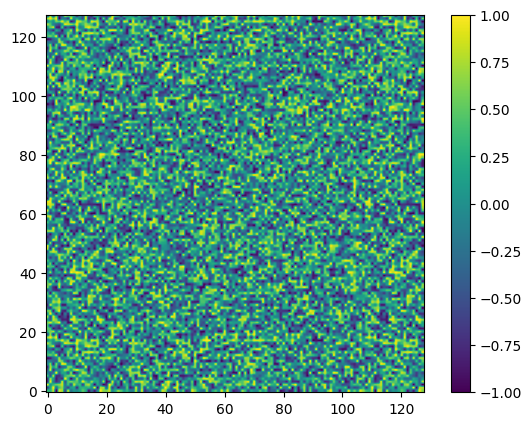

In [47]:
update_halo(field, num_halo=10)
plot_field(field)
np.array_equal(field, copy_field)

True

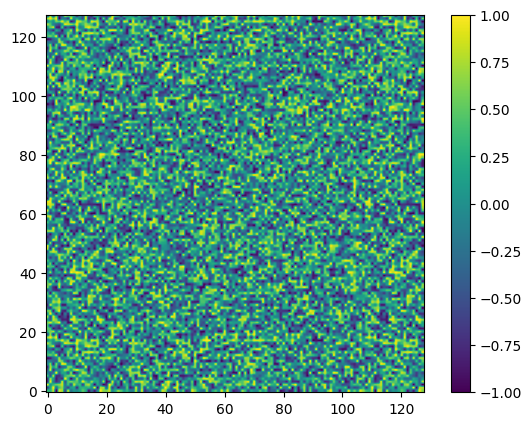

In [48]:
update_halo_numba(copy_field, num_halo=10)
plot_field(copy_field)
np.array_equal(field, copy_field)

Let's now verify that the `update_halo_numba()` is at least as fast as `update_halo()`

In [49]:
%%timeit
field, copy_field = initialize_fields(NX, NY, NZ, mode="random")
update_halo(field, num_halo=2)

11.6 ms ± 56.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
%%timeit
field, copy_field = initialize_fields(NX, NY, NZ, mode="random")
update_halo_numba(field, num_halo=2)

11.6 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


There is not a noticeable speedup in this case, but at least we have not make the numpy code worse.

Finally, we implement the diffusion operator using an explicit definition of the discretization rather than calling two times the laplacian operator. In the future, if `@stencil` is extended with additional `func_or_mode`, perhaps is possible to implement a similar `laplacian_numba()` function with an `extend` argument, similar to how is done in the `stencil2d` module.

In [51]:
@jit(nopython=True, parallel=True)
def apply_diffusion_numba(in_field, out_field, num_halo, num_iter=1):
    alpha = 1.0 / 32.0

    for n in range(num_iter):
        # Periodic boundary conditions are achieved updating the halo region before applying the diffusion operator
        update_halo_numba(in_field, num_halo)

        # 4th-order diffusion operator (spatial update)
        for k in prange(NZ):
            # Loops iterate over all computation domain (without halo)
            for j in range(NY - 2 * num_halo):
                for i in range(NX - 2 * num_halo):
                    out_field[k, j, i] = 20 * in_field[k, j, i] \
                        - 8 * (in_field[k, j, i+1] + in_field[k, j, i-1] + in_field[k, j+1, i] + in_field[k, j-1, i]) \
                        + 2 * (in_field[k, j+1, i+1] + in_field[k, j+1, i-1] + in_field[k, j-1, i+1] + in_field[k, j-1, i-1]) \
                        + in_field[k, j, i+2] + in_field[k, j, i-2] + in_field[k, j+2, i] + in_field[k, j-2, i]

        # 4th-order diffusion operator (temporal update)
        for k in prange(NZ):
            for j in range(NY - 2 * num_halo):
                for i in range(NX - 2 * num_halo):
                    out_field[k, num_halo + j, num_halo + i] = \
                        in_field[k, num_halo + j, num_halo + i] - alpha * out_field[k, num_halo + j, num_halo + i]

        if n < num_iter - 1:
            in_field, out_field = out_field, in_field
        else:
            update_halo_numba(out_field, num_halo)

Let's first test the correctness of this implementation, which will also allow Numba to compile the function before running the benchmark.

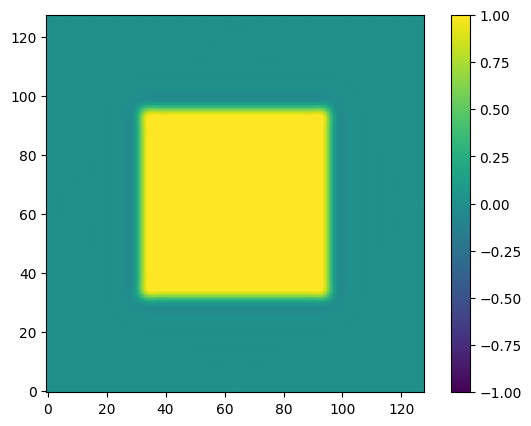

In [52]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square", num_halo=0)
in_field2, out_field2 = initialize_fields(NX, NY, NZ, mode="square", num_halo=0)

apply_diffusion(in_field, out_field, num_halo=2, num_iter=N_ITER)
apply_diffusion_numba(in_field2, out_field2, num_halo=2, num_iter=N_ITER)

# There might be small differences (< 1e-7) due to different numerical errors
# Better to test with almost_equal than with np.array_equal()
np.testing.assert_almost_equal(out_field, out_field2)
plot_field(out_field2)

In [53]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
apply_diffusion(in_field, out_field, num_halo=2, num_iter=N_ITER)

1.08 s ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
apply_diffusion_numba(in_field, out_field, num_halo=2, num_iter=N_ITER)

31.6 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Using all the accelerators mentioned at the beginning of the notebook we were able to make the diffusion stencil with Numba **~30x faster** than the numpy code from `stencil2d.py`. Once again, this agrees with the claims from the Numba documentation.

# Conclusions

- Numba is very easy to use
- Numba makes "normal" python code with Numpy arrays faster
- It is easy to parallelize the code and even avoid Python’s global interpreter lock (GIL) with `parallel=True` and `prange`
- Numba makes NumPy "vectorial" code slower (this agrees with some numbers from the Numba docs, e.g., section 1.14.2)
- It is not always clear if there is a gain or not, one has to do a test every time with and without `@njit`
- Observed speedup agrees with claims from docs (1-2 orders of magnitude)